<a href="https://colab.research.google.com/github/dookda/cmu_udfire_gee/blob/main/dew.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Forest Change Detection using Sentinel-2 Data (2016 vs 2024)

This notebook detects forest cover changes between 2016 and 2024 using Sentinel-2 satellite imagery.

**Note**: We use 2016 as the baseline year instead of 2015 because Sentinel-2 data availability was limited in 2015 (started in June 2015).

## 1. Setup and Initialization

In [6]:
# Import required libraries
import ee
import geemap
import json
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import calendar

# Initialize Earth Engine with project
ee.Authenticate()
try:
    ee.Initialize(project="ee-sakda-451407")
    print("Earth Engine initialized successfully!")
except Exception as e:
    ee.Authenticate()
    ee.Initialize(project="ee-sakda-451407")
    print("Earth Engine authenticated and initialized!")

Earth Engine initialized successfully!


## 2. Define Area of Interest

In [7]:
# Define the area of interest (AOI)
aoi_geojson = {
    "type": "Feature",
    "properties": {
        "name": "Converted Polygon"
    },
    "geometry": {
        "type": "Polygon",
        "coordinates": [
            [
                [100.88964783624543, 17.025106397335236],
                [100.91140353057993, 17.025033245134257],
                [100.9111120771334, 17.000597462154097],
                [100.89209936939791, 16.99974772362222],
                [100.88964783624543, 17.025106397335236]
            ]
        ]
    }
}

# Convert GeoJSON to Earth Engine geometry
aoi = ee.Geometry.Polygon(aoi_geojson['geometry']['coordinates'])
print(f"Area of Interest: {aoi_geojson['properties']['name']}")
print(f"Coordinates: {aoi.coordinates().getInfo()}")

Area of Interest: Converted Polygon
Coordinates: [[[100.88964783624543, 17.025106397335236], [100.89209936939791, 16.99974772362222], [100.9111120771334, 17.000597462154097], [100.91140353057993, 17.025033245134257], [100.88964783624543, 17.025106397335236]]]


In [8]:
# DIAGNOSTIC: Check data availability for this area
print("Running diagnostics...")
print("\nArea of Interest:")
print(f"  Center: {aoi.centroid().coordinates().getInfo()}")
print(f"  Area: {aoi.area().divide(1000000).getInfo():.4f} km²")

# Check a single recent image to verify the area is valid
print("\nChecking for recent Sentinel-2 images...")
test_collection = ee.ImageCollection('COPERNICUS/S2_SR') \
    .filterBounds(aoi) \
    .filterDate('2024-01-01', '2024-12-31') \
    .limit(1)

test_count = test_collection.size().getInfo()
print(f"  Found {test_count} test image(s)")

if test_count > 0:
    test_img = test_collection.first()
    print(f"  Test image ID: {test_img.get('system:index').getInfo()}")
    print(f"  Test image date: {ee.Date(test_img.get('system:time_start')).format('YYYY-MM-dd').getInfo()}")
    print(f"  Test image bands: {test_img.bandNames().getInfo()}")
    print(f"  Cloud cover: {test_img.get('CLOUDY_PIXEL_PERCENTAGE').getInfo():.1f}%")

    # Try to get a pixel value to ensure data exists in this area
    center = aoi.centroid()
    sample = test_img.sample(center, 10).first().getInfo()
    print(f"  Sample pixel data: {list(sample['properties'].keys())[:5]}...")
    print("\n✓ Data is available for this area!")
else:
    print("\n✗ ERROR: No Sentinel-2 data found for this area!")
    print("  This could mean:")
    print("  - The coordinates are incorrect")
    print("  - The area is outside Sentinel-2 coverage")
    raise Exception("No data available for this location")

Running diagnostics...

Area of Interest:
  Center: [100.90098733683418, 17.012894810342228]
  Area: 6.0054 km²

Checking for recent Sentinel-2 images...
  Found 1 test image(s)
  Test image ID: 20240101T034141_20240101T034430_T47QPU
  Test image date: 2024-01-01
  Test image bands: ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B9', 'B11', 'B12', 'AOT', 'WVP', 'SCL', 'TCI_R', 'TCI_G', 'TCI_B', 'MSK_CLDPRB', 'MSK_SNWPRB', 'QA10', 'QA20', 'QA60']
  Cloud cover: 6.5%
  Sample pixel data: ['AOT', 'B1', 'B11', 'B12', 'B2']...

✓ Data is available for this area!


## 3. Define Helper Functions

In [9]:
def get_sentinel2_composite(start_date, end_date, aoi):
    """
    Get Sentinel-2 composite for a specific time period
    Uses a simple approach: take all available images and create median composite
    """
    print(f"\n  Searching for images from {start_date} to {end_date}...")

    # Get all available images
    collection = ee.ImageCollection('COPERNICUS/S2_SR') \
        .filterBounds(aoi) \
        .filterDate(start_date, end_date)

    count = collection.size().getInfo()
    print(f"  Found {count} images")

    if count == 0:
        raise Exception(f"No images found for {start_date} to {end_date}")

    # Get info about the images
    first_img = collection.first()
    print(f"  First image date: {ee.Date(first_img.get('system:time_start')).format('YYYY-MM-dd').getInfo()}")

    # Get cloud statistics
    cloud_stats = collection.aggregate_array('CLOUDY_PIXEL_PERCENTAGE').getInfo()
    avg_cloud = sum(cloud_stats) / len(cloud_stats) if cloud_stats else 0
    min_cloud = min(cloud_stats) if cloud_stats else 0
    print(f"  Cloud coverage: avg={avg_cloud:.1f}%, min={min_cloud:.1f}%")

    # Filter to less cloudy images
    collection_filtered = collection.filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 60))
    count_filtered = collection_filtered.size().getInfo()
    print(f"  Using {count_filtered} images with <60% cloud cover")

    if count_filtered == 0:
        print(f"  WARNING: All images very cloudy, using all {count} images")
        collection_filtered = collection

    # Select optical bands and scale
    def prep_image(image):
        # Select only the optical bands we need
        return image.select(['B2', 'B3', 'B4', 'B8']).divide(10000)

    collection_prepped = collection_filtered.map(prep_image)

    # Create median composite
    composite = collection_prepped.median().clip(aoi)

    # Verify composite has data
    bands = composite.bandNames().getInfo()
    print(f"  Composite created with bands: {bands}")

    if not bands:
        raise Exception("Composite has no bands - this shouldn't happen!")

    return composite

def calculate_ndvi(image):
    """
    Calculate Normalized Difference Vegetation Index (NDVI)
    """
    ndvi = image.normalizedDifference(['B8', 'B4']).rename('NDVI')
    return ndvi

def classify_forest(ndvi_image, threshold=0.5):
    """
    Classify forest areas based on NDVI threshold
    Forest areas typically have NDVI > 0.5
    """
    forest = ndvi_image.gt(threshold).rename('forest')
    return forest

print("Helper functions defined!")

Helper functions defined!


## 4. Load and Process Sentinel-2 Data

In [10]:
# Define time periods
period_2015_start = '2016-11-01'
period_2015_end = '2017-03-30'

period_2024_start = '2024-01-01'
period_2024_end = '2024-03-30'

print("="*60)
print("CREATING SENTINEL-2 COMPOSITES")
print("="*60)
print(f"Baseline period: {period_2015_start} to {period_2015_end}")
print(f"Current period: {period_2024_start} to {period_2024_end}")

print("\n[1/2] Creating 2016 composite (baseline)...")
composite_2015 = get_sentinel2_composite(period_2015_start, period_2015_end, aoi)

print("\n[2/2] Creating 2024 composite (current)...")
composite_2024 = get_sentinel2_composite(period_2024_start, period_2024_end, aoi)

print("\n" + "="*60)
print("✓ SUCCESS: Both composites created!")
print("="*60)

CREATING SENTINEL-2 COMPOSITES
Baseline period: 2016-11-01 to 2017-03-30
Current period: 2024-01-01 to 2024-03-30

[1/2] Creating 2016 composite (baseline)...

  Searching for images from 2016-11-01 to 2017-03-30...
  Found 2 images
  First image date: 2017-02-06
  Cloud coverage: avg=0.0%, min=0.0%
  Using 2 images with <60% cloud cover
  Composite created with bands: ['B2', 'B3', 'B4', 'B8']

[2/2] Creating 2024 composite (current)...

  Searching for images from 2024-01-01 to 2024-03-30...
  Found 36 images
  First image date: 2024-01-01
  Cloud coverage: avg=24.1%, min=0.0%
  Using 32 images with <60% cloud cover
  Composite created with bands: ['B2', 'B3', 'B4', 'B8']

✓ SUCCESS: Both composites created!


## 5. Calculate NDVI and Classify Forest

In [11]:
# Calculate NDVI for both periods
print("="*60)
print("CALCULATING NDVI AND CLASSIFYING FOREST")
print("="*60)

print("\nCalculating NDVI...")
ndvi_2015 = calculate_ndvi(composite_2015)
ndvi_2024 = calculate_ndvi(composite_2024)
print("✓ NDVI calculated")

print("\nClassifying forest areas (NDVI > 0.4)...")
forest_2015 = classify_forest(ndvi_2015, threshold=0.4)
forest_2024 = classify_forest(ndvi_2024, threshold=0.4)
print("✓ Forest classification complete")

print("\n" + "="*60)
print("✓ SUCCESS: NDVI and forest classification done!")
print("="*60)

CALCULATING NDVI AND CLASSIFYING FOREST

Calculating NDVI...
✓ NDVI calculated

Classifying forest areas (NDVI > 0.4)...
✓ Forest classification complete

✓ SUCCESS: NDVI and forest classification done!


## 6. Detect Forest Changes

In [12]:
# Detect changes
print("Detecting forest changes...")

# Forest loss: was forest in 2015 (1) but not in 2024 (0)
forest_loss = forest_2015.And(forest_2024.Not()).rename('forest_loss')

# Forest gain: was not forest in 2015 (0) but is forest in 2024 (1)
forest_gain = forest_2015.Not().And(forest_2024).rename('forest_gain')

# No change - remained forest
forest_stable = forest_2015.And(forest_2024).rename('forest_stable')

# No change - remained non-forest
non_forest_stable = forest_2015.Not().And(forest_2024.Not()).rename('non_forest_stable')

# Create a change map
# 0: No change (non-forest), 1: Forest stable, 2: Forest loss, 3: Forest gain
change_map = ee.Image(0) \
    .where(forest_stable, 1) \
    .where(forest_loss, 2) \
    .where(forest_gain, 3) \
    .rename('change_category')

print("Forest change detection complete!")

Detecting forest changes...
Forest change detection complete!


## 7. Calculate Statistics

In [13]:
# Calculate statistics
print("Calculating statistics...")
area_image = ee.Image.pixelArea()

def calculate_area(image, aoi):
    area = image.multiply(area_image).reduceRegion(
        reducer=ee.Reducer.sum(),
        geometry=aoi,
        scale=10,  # Sentinel-2 resolution
        maxPixels=1e9
    )
    return area

# Calculate areas
forest_2015_area = calculate_area(forest_2015, aoi)
forest_2024_area = calculate_area(forest_2024, aoi)
forest_loss_area = calculate_area(forest_loss, aoi)
forest_gain_area = calculate_area(forest_gain, aoi)

# Get the values and convert to square kilometers (km²)
# Area is returned in m², divide by 1,000,000 to get km²
stats = {
    'forest_2015_km2': forest_2015_area.getInfo()['forest'] / 1000000 if 'forest' in forest_2015_area.getInfo() else 0,
    'forest_2024_km2': forest_2024_area.getInfo()['forest'] / 1000000 if 'forest' in forest_2024_area.getInfo() else 0,
    'forest_loss_km2': forest_loss_area.getInfo()['forest_loss'] / 1000000 if 'forest_loss' in forest_loss_area.getInfo() else 0,
    'forest_gain_km2': forest_gain_area.getInfo()['forest_gain'] / 1000000 if 'forest_gain' in forest_gain_area.getInfo() else 0,
}

stats['net_change_km2'] = stats['forest_2024_km2'] - stats['forest_2015_km2']
stats['percent_change'] = (stats['net_change_km2'] / stats['forest_2015_km2'] * 100) if stats['forest_2015_km2'] > 0 else 0

print("\n" + "="*60)
print("FOREST CHANGE DETECTION RESULTS")
print("="*60)
print(f"Forest area in 2016 (baseline): {stats['forest_2015_km2']:.4f} km²")
print(f"Forest area in 2024 (current): {stats['forest_2024_km2']:.4f} km²")
print(f"Forest loss: {stats['forest_loss_km2']:.4f} km²")
print(f"Forest gain: {stats['forest_gain_km2']:.4f} km²")
print(f"Net change: {stats['net_change_km2']:.4f} km² ({stats['percent_change']:.2f}%)")
print("="*60)

# Save statistics to JSON
with open('forest_change_stats.json', 'w') as f:
    json.dump(stats, f, indent=2)
print("\nStatistics saved to: forest_change_stats.json")

Calculating statistics...

FOREST CHANGE DETECTION RESULTS
Forest area in 2016 (baseline): 0.8157 km²
Forest area in 2024 (current): 0.9527 km²
Forest loss: 0.3065 km²
Forest gain: 0.4435 km²
Net change: 0.1370 km² (16.80%)

Statistics saved to: forest_change_stats.json


## 8. Visualize Results on Interactive Map

In [18]:
# Create an interactive map
Map = geemap.Map(center=[17.0125, 100.9], zoom=13)

# Add boundary
Map.addLayer(aoi, {'color': 'yellow'}, 'AOI Boundary')

# Visualization parameters
rgb_vis = {
    'min': 0.0,
    'max': 0.3,
    'bands': ['B4', 'B3', 'B2']
}

ndvi_vis = {
    'min': 0,
    'max': 1,
    'palette': ['red', 'yellow', 'green']
}

change_vis = {
    'min': 0,
    'max': 3,
    'palette': ['white', 'green', 'red', 'blue']
}

# Add layers to map
Map.addLayer(composite_2015, rgb_vis, 'Sentinel-2 2015', False)
Map.addLayer(composite_2024, rgb_vis, 'Sentinel-2 2024', False)
Map.addLayer(ndvi_2015, ndvi_vis, 'NDVI 2015', False)
Map.addLayer(ndvi_2024, ndvi_vis, 'NDVI 2024', False)
Map.addLayer(forest_2015, {'palette': ['white', 'darkgreen']}, 'Forest 2015', False)
Map.addLayer(forest_2024, {'palette': ['white', 'darkgreen']}, 'Forest 2024', False)
Map.addLayer(change_map, change_vis, 'Forest Change Map', True)

# Add legend
legend_dict = {
    'No Change (Non-Forest)': (255, 255, 255), # White
    'Forest (Stable)': (0, 128, 0),          # Green
    'Forest Loss': (255, 0, 0),             # Red
    'Forest Gain': (0, 0, 255)              # Blue
}
Map.add_legend(title='Forest Change', legend_dict=legend_dict)

# Display the map
Map

Map(center=[17.0125, 100.9], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchData…

## 9. Export Results (Optional)

In [19]:
# Export change map to Google Drive
export_task = ee.batch.Export.image.toDrive(
    image=change_map.clip(aoi),
    description='forest_change_2015_2024',
    folder='_GEE_data',
    region=aoi,
    scale=10,
    maxPixels=1e9
)

# Uncomment to start export
# export_task.start()
print('Export task started. Check your Google Drive folder: _GEE_data')

# print("To export, uncomment the lines above and run this cell again.")

Export task started. Check your Google Drive folder: _GEE_data


## 10. Create Comparison Charts

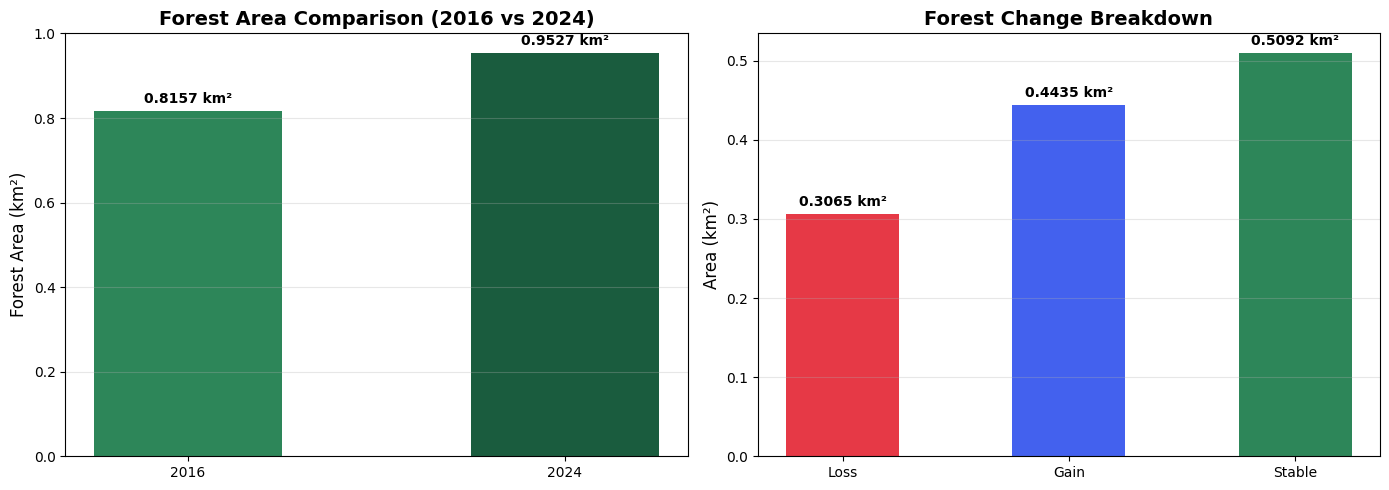

Chart saved as: forest_change_analysis.png


In [20]:
import matplotlib.pyplot as plt

# Create bar chart for forest area comparison
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Forest area comparison
years = ['2016', '2024']
areas = [stats['forest_2015_km2'], stats['forest_2024_km2']]
colors = ['#2d8659', '#1a5c3e']

ax1.bar(years, areas, color=colors, width=0.5)
ax1.set_ylabel('Forest Area (km²)', fontsize=12)
ax1.set_title('Forest Area Comparison (2016 vs 2024)', fontsize=14, fontweight='bold')
ax1.grid(axis='y', alpha=0.3)
for i, v in enumerate(areas):
    ax1.text(i, v + max(areas)*0.02, f'{v:.4f} km²', ha='center', fontweight='bold')

# Forest change breakdown
categories = ['Loss', 'Gain', 'Stable']
values = [
    stats['forest_loss_km2'],
    stats['forest_gain_km2'],
    stats['forest_2015_km2'] - stats['forest_loss_km2']  # Stable forest
]
change_colors = ['#e63946', '#4361ee', '#2d8659']

ax2.bar(categories, values, color=change_colors, width=0.5)
ax2.set_ylabel('Area (km²)', fontsize=12)
ax2.set_title('Forest Change Breakdown', fontsize=14, fontweight='bold')
ax2.grid(axis='y', alpha=0.3)
for i, v in enumerate(values):
    ax2.text(i, v + max(values)*0.02, f'{v:.4f} km²', ha='center', fontweight='bold')

plt.tight_layout()
plt.savefig('forest_change_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("Chart saved as: forest_change_analysis.png")